In [1]:
import sys
sys.path.append('../src')
sys.path.append('../src/data/')
sys.path.append('../src/models/')
sys.path.append('../src/features/')
sys.path.append('../src/visualization/')
# will reload any library
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

print ("finished")

finished


In [2]:
# sportify specific
#from data.metrics import r_precision, cosine_sim_closest, cosine_sim_top, NDCG
from visualization.plot_utils import write_latex_table, summary_pooling_table,\
pooling_plots, pandas_settings, plot_settings,  save_result
# general
import pandas as pd
import numpy as np
from tqdm import tqdm
from features import AudioFeatures, TrackInfo, Popularity, GenreFeatures, Word2vecFeature
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from data import compressed_pickle as cpick
plot_settings()
pandas_settings()

In [3]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sense2vec.vectors import VectorMap
from gensim.models import Word2Vec
import sys
from os.path import join as path_join
sys.path.append('../src')
sys.path.append('../src/data/')
sys.path.append('../src/models/')
sys.path.append('../src/features/')
sys.path.append('../src/visualization/')
# will reload any library

SAVE_PATH = '../data/sense2vec'

label = 'trackgenre_128_1cut'
model_path = path_join(SAVE_PATH, label)
gensim_model = Word2Vec.load(model_path)
vector_map = VectorMap(128)

min_count = gensim_model.min_count
for string in gensim_model.wv.vocab:
    vocab = gensim_model.wv.vocab[string]
    freq, idx = vocab.count, vocab.index
    if freq < min_count:
        continue
    vector = gensim_model.wv.syn0[idx]
    vector_map.borrow(string, freq, vector)

vector_map.save(SAVE_PATH)

2018-05-07 20:50:33,131 : INFO : loading Word2Vec object from ../data/sense2vec/trackgenre_128_1cut
2018-05-07 20:50:36,299 : INFO : loading wv recursively from ../data/sense2vec/trackgenre_128_1cut.wv.* with mmap=None
2018-05-07 20:50:36,299 : INFO : loading vectors from ../data/sense2vec/trackgenre_128_1cut.wv.vectors.npy with mmap=None
2018-05-07 20:50:36,648 : INFO : setting ignored attribute vectors_norm to None
2018-05-07 20:50:36,648 : INFO : loading vocabulary recursively from ../data/sense2vec/trackgenre_128_1cut.vocabulary.* with mmap=None
2018-05-07 20:50:36,649 : INFO : loading trainables recursively from ../data/sense2vec/trackgenre_128_1cut.trainables.* with mmap=None
2018-05-07 20:50:36,649 : INFO : loading syn1neg from ../data/sense2vec/trackgenre_128_1cut.trainables.syn1neg.npy with mmap=None
2018-05-07 20:50:37,154 : INFO : setting ignored attribute cum_table to None
2018-05-07 20:50:37,155 : INFO : loaded ../data/sense2vec/trackgenre_128_1cut
/home/beangoben/anaconda

In [4]:
DATA_PATH = '../data/interim'
tints2turis = cpick.load(path_join(DATA_PATH, 'track_int2track_uri.pkl.bz2'))
turis2gtopic = cpick.load(path_join(DATA_PATH, 'track_uri2gtopics.pkl.bz2'))
pl2tints = cpick.load(path_join(DATA_PATH, 'playlist2track_ints.pkl.bz2'))

pl2sense = []
for pl in pl2tints[:5000]:
    for tint in pl:
        turi = tints2turis[tint]
        word = '{}|{}'.format(turi, turis2gtopic[turi])
        pl2sense.append(word)
pl2sense = list(set(pl2sense))
gtopic=[int(s.split('|')[-1]) for s in pl2sense]
print(len(pl2sense))

108870


In [5]:
X = [ ]
for word in pl2sense:
    f,v = vector_map[word]
    X.append(v)
X = np.array(X)
X.shape

(108870, 128)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_pre = StandardScaler().fit_transform(X)
print(X_pre.shape)
X_pca = PCA(n_components=50).fit_transform(X_pre)
print(X_pca.shape)
X_emb = TSNE(n_components=2,init='pca').fit_transform(X_pca)
print(X_emb.shape)

(108870, 128)


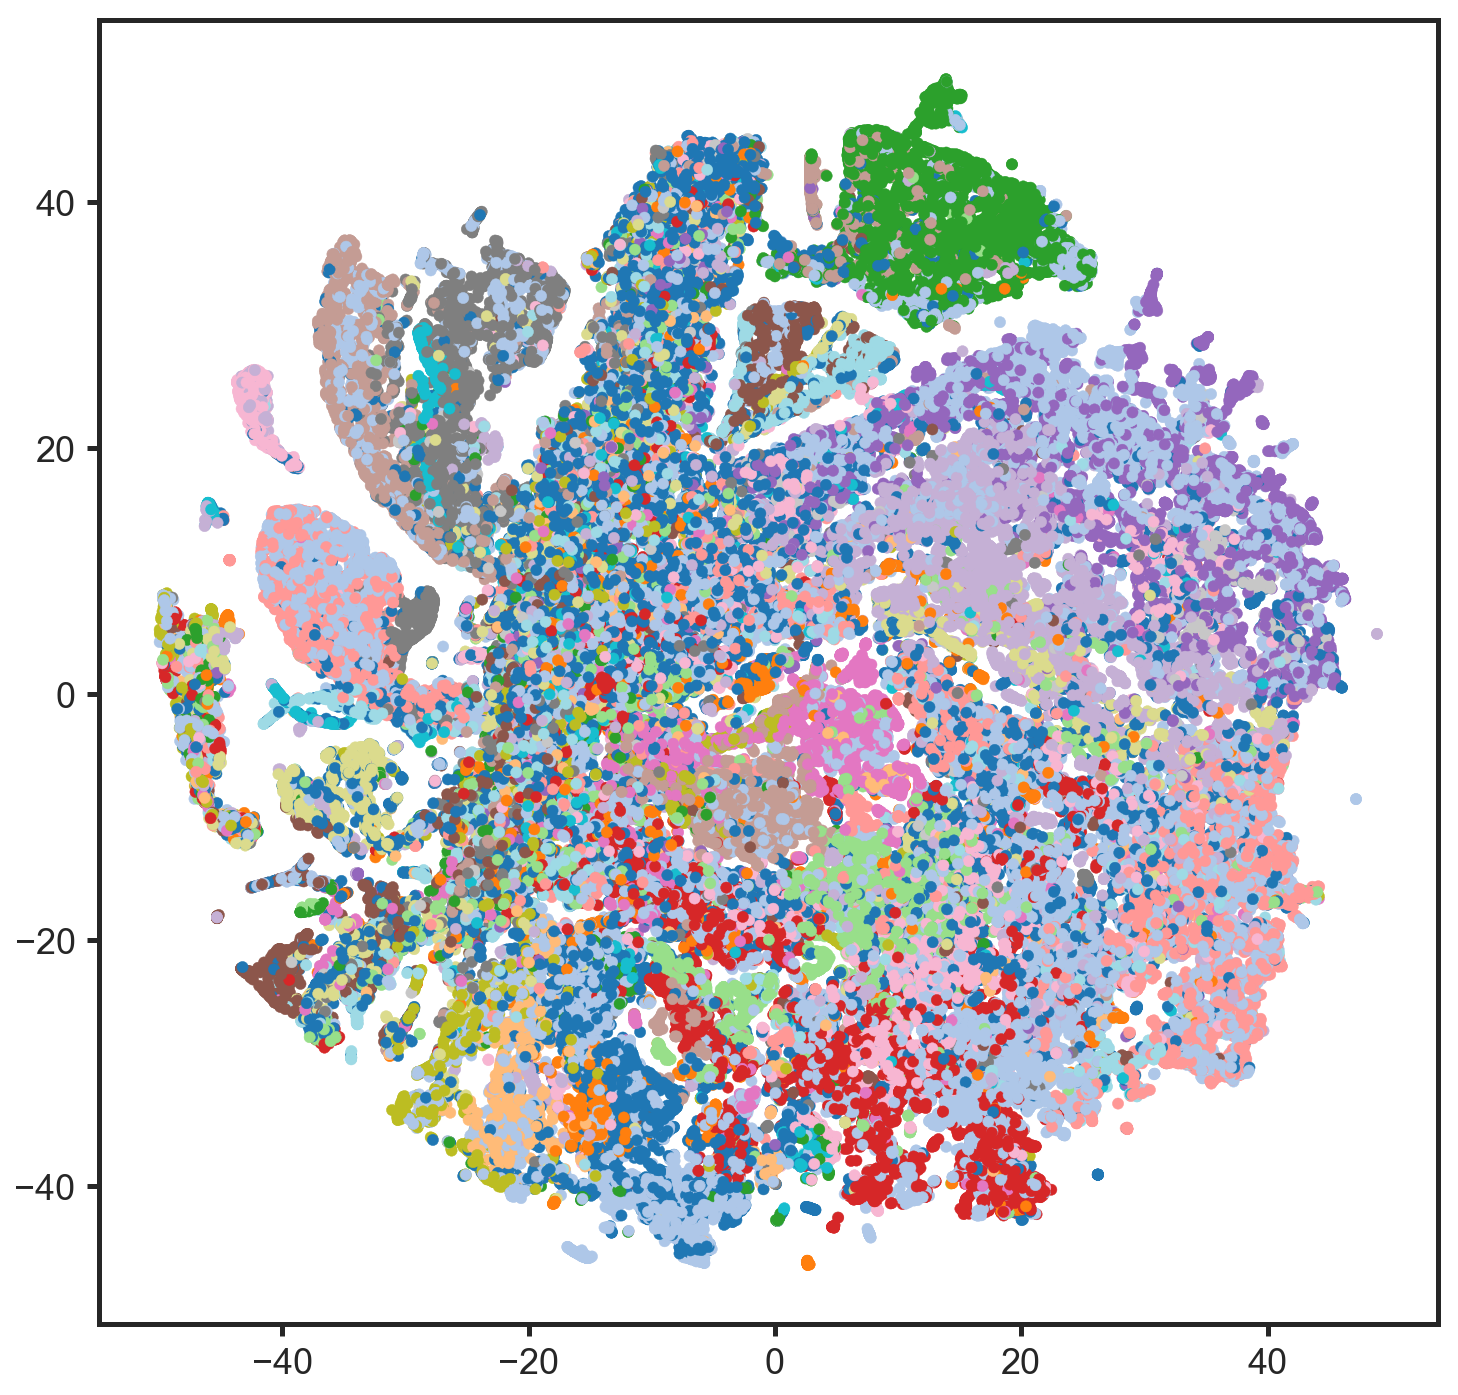

In [15]:
plt.figure(figsize=(12,12))
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=c)

In [21]:
X_sub = np.array([x for indx,x in enumerate(X_emb) if gtopic[indx] < 5])
g_sub = [gtopic[indx] for indx,x in enumerate(X_emb) if gtopic[indx] < 5]
pal = sns.color_palette('Set2',len(set(g_sub)))
c = [list(pal[g]) for g in g_sub]

In [ ]:
2018-05-04 05:40:58,696 : INFO : topic #1 (0.047): 0.060*"modern rock" + 0.045*"indie pop" + 0.041*"indie rock" + 0.035*"indietronica" + 0.025*"indie folk" + 0.024*"chamber pop" + 0.021*"folk-pop" + 0.021*"shimmer pop" + 0.021*"synthpop" + 0.020*"neo-psychedelic"
2018-05-04 05:40:58,696 : INFO : topic #5 (0.047): 0.043*"pop" + 0.041*"dance pop" + 0.036*"neo mellow" + 0.035*"pop rock" + 0.035*"pop rap" + 0.029*"modern rock" + 0.027*"indie folk" + 0.026*"alternative rock" + 0.022*"folk-pop" + 0.022*"indie pop"
2018-05-04 05:40:58,697 : INFO : topic #4 (0.048): 0.091*"pop" + 0.065*"dance pop" + 0.059*"post-teen pop" + 0.040*"r&b" + 0.034*"urban contemporary" + 0.032*"pop rap" + 0.028*"hip pop" + 0.025*"singer-songwriter" + 0.019*"rap" + 0.018*"indie r&b"
2018-05-04 05:40:58,698 : INFO : topic #3 (0.048): 0.060*"pop" + 0.034*"dance pop" + 0.031*"rap" + 0.029*"pop rap" + 0.025*"r&b" + 0.022*"modern rock" + 0.022*"hip hop" + 0.021*"pop rock" + 0.021*"post-teen pop" + 0.021*"neo mellow"
2018-05-04 05:40:58,699 : INFO : topic #11 (0.049): 0.070*"contemporary country" + 0.069*"country road" + 0.063*"country" + 0.049*"pop" + 0.039*"modern country rock" + 0.037*"pop rock" + 0.031*"dance pop" + 0.030*"neo mellow" + 0.025*"post-grunge" + 0.023*"alternative metal"
2018-05-04 05:40:58,700 : INFO : topic diff=21.435526, rho=1.000000
2018-05-04 05:40:58,734 : INFO : PROGRESS: pass 0, at document #20000/2262292
2018-05-04 05:41:00,236 : INFO : optimized alpha [0.04541312, 0.046791703, 0.045060158, 0.045874376, 0.04724829, 0.0451185, 0.045470558, 0.047028895, 0.047305487, 0.045272317, 0.0464478, 0.049770385, 0.044700436, 0.044978112, 0.046247732, 0.044985153, 0.046443086, 0.04686931, 0.0450601, 0.04469828]
2018-05-04 05:41:00,237 : INFO : merging changes from 10000 documents into a model of 2262292 documents
2018-05-04 05:41:00,241 : INFO : topic #19 (0.045): 0.049*"post-teen pop" + 0.043*"pop" + 0.034*"dance pop" + 0.029*"deep pop r&b" + 0.028*"boy band" + 0.022*"electronic trap" + 0.021*"reggae rock" + 0.020*"pop punk" + 0.019*"mizrahi" + 0.017*"southern soul"
2018-05-04 05:41:00,242 : INFO : topic #12 (0.045): 0.045*"pop rap" + 0.044*"punk" + 0.041*"rap" + 0.037*"hip hop" + 0.035*"skate punk" + 0.029*"pop punk" + 0.029*"rock" + 0.026*"southern hip hop" + 0.022*"christian relaxative" + 0.021*"trap music"
2018-05-04 05:41:00,242 : INFO : topic #4 (0.047): 0.078*"pop" + 0.067*"dance pop" + 0.054*"r&b" + 0.053*"post-teen pop" + 0.045*"urban contemporary" + 0.043*"traditional country" + 0.041*"outlaw country" + 0.033*"pop rap" + 0.033*"hip pop" + 0.030*"texas country"
2018-05-04 05:41:00,243 : INFO : topic #8 (0.047): 0.134*"rap" + 0.121*"pop rap" + 0.112*"hip hop" + 0.085*"southern hip hop" + 0.081*"trap music" + 0.067*"pop" + 0.041*"gangster rap" + 0.040*"dirty south rap" + 0.034*"dance pop" + 0.025*"r&b"
2018-05-04 05:41:00,244 : INFO : topic #11 (0.050): 0.113*"contemporary country" + 0.101*"country road" + 0.088*"country" + 0.063*"modern country rock" + 0.051*"alternative metal" + 0.044*"post-grunge" + 0.042*"nu metal" + 0.034*"rap metal" + 0.033*"regional mexican" + 0.026*"banda"
2018-05-04 05:41:00,244 : INFO : topic diff=10.981655, rho=0.707107
2018-05-04 05:41:00,283 : INFO : PROGRESS: pass 0, at document #30000/2262292
2018-05-04 05:41:01,465 : INFO : optimized alpha [0.044458542, 0.046666753, 0.043651305, 0.044411283, 0.045834333, 0.044298053, 0.044616975, 0.04632146, 0.048669025, 0.044115514, 0.04554224, 0.050022665, 0.042776283, 0.043293796, 0.045300703, 0.043276034, 0.046039347, 0.047562644, 0.04344567, 0.043223064]
2018-05-04 05:41:01,465 : INFO : merging changes from 10000 documents into a model of 2262292 documents
2018-05-04 05:41:01,470 : INFO : topic #12 (0.043): 0.048*"punk" + 0.043*"pop punk" + 0.041*"dreamo" + 0.033*"skate punk" + 0.032*"rock" + 0.032*"pop rap" + 0.031*"modern rock" + 0.028*"rap" + 0.026*"hip hop" + 0.020*"permanent wave"
2018-05-04 05:41:01,470 : INFO : topic #19 (0.043): 0.047*"boy band" + 0.044*"post-teen pop" + 0.040*"pop" + 0.035*"reggae rock" + 0.030*"deep pop r&b" + 0.027*"southern soul" + 0.026*"pop punk" + 0.025*"wonky" + 0.023*"indie r&b" + 0.023*"southern soul blues"
2018-05-04 05:41:01,471 : INFO : topic #17 (0.048): 0.164*"pop" + 0.141*"post-teen pop" + 0.132*"dance pop" + 0.053*"hollywood" + 0.046*"broadway" + 0.043*"show tunes" + 0.039*"viral pop" + 0.019*"canadian pop" + 0.015*"classical" + 0.015*"teen pop"
2018-05-04 05:41:01,472 : INFO : topic #8 (0.049): 0.147*"rap" + 0.129*"pop rap" + 0.115*"hip hop" + 0.098*"trap music" + 0.096*"southern hip hop" + 0.063*"pop" + 0.052*"gangster rap" + 0.051*"dirty south rap" + 0.027*"dance pop" + 0.020*"r&b"
2018-05-04 05:41:01,472 : INFO : topic #11 (0.050): 0.107*"contemporary country" + 0.097*"country road" + 0.087*"country" + 0.076*"alternative metal" + 0.062*"modern country rock" + 0.060*"post-grunge" + 0.058*"nu metal" + 0.052*"rap metal" + 0.035*"rap rock" + 0.030*"regional mexican"
2018-05-04 05:41:01,473 : INFO : topic diff=4.883575, rho=0.577350
2018-05-04 05:41:01,507 : INFO : PROGRESS: pass 0, at document #40000/2262292
2018-05-04 05:41:02,644 : INFO : optimized alpha [0.043349538, 0.046790212, 0.042385824, 0.04306932, 0.044479027, 0.043827664, 0.04362221, 0.04682315, 0.049049795, 0.043812405, 0.044809442, 0.05036066, 0.041505933, 0.042147826, 0.044606414, 0.041923907, 0.04596498, 0.047877405, 0.04219166, 0.042039827]
2018-05-04 05:41:02,645 : INFO : merging changes from 10000 documents into a model of 2262292 documents
2018-05-04 05:41:02,650 : INFO : topic #12 (0.042): 0.095*"pop punk" + 0.066*"punk" + 0.064*"modern rock" + 0.051*"emo" + 0.049*"alternative emo" + 0.043*"dreamo" + 0.037*"skate punk" + 0.035*"post-hardcore" + 0.035*"screamo" + 0.026*"melodic hardcore"
2018-05-04 05:41:02,650 : INFO : topic #15 (0.042): 0.120*"underground hip hop" + 0.089*"trap music" + 0.085*"vapor trap" + 0.064*"rap" + 0.042*"pop" + 0.042*"southern hip hop" + 0.030*"dwn trap" + 0.025*"pop rap" + 0.024*"drill" + 0.024*"deep trap"
2018-05-04 05:41:02,651 : INFO : topic #17 (0.048): 0.169*"pop" + 0.150*"post-teen pop" + 0.140*"dance pop" + 0.053*"hollywood" + 0.050*"viral pop" + 0.041*"broadway" + 0.039*"show tunes" + 0.031*"soundtrack" + 0.023*"classical" + 0.016*"teen pop"
2018-05-04 05:41:02,651 : INFO : topic #8 (0.049): 0.143*"rap" + 0.131*"pop rap" + 0.120*"hip hop" + 0.096*"southern hip hop" + 0.092*"trap music" + 0.061*"pop" + 0.060*"gangster rap" + 0.051*"dirty south rap" + 0.025*"dance pop" + 0.018*"r&b"
2018-05-04 05:41:02,652 : INFO : topic #11 (0.050): 0.101*"contemporary country" + 0.092*"country road" + 0.087*"country" + 0.075*"alternative metal" + 0.063*"post-grunge" + 0.058*"nu metal" + 0.054*"modern country rock" + 0.051*"rap metal" + 0.038*"regional mexican" + 0.034*"rap rock"

In [53]:
genre_topics=OrderedDict()
genre_topics[0]='Rock-like'
genre_topics[1]='Pop-like'
genre_topics[2]='Funk-like'
genre_topics[3]='Metal-like'
genre_topics[4]='Jazz-like'
genre_topics[5]='Hip hop-like'

In [36]:
pal[0]

(0.40000000000000002, 0.76078431372549016, 0.6470588235294118)

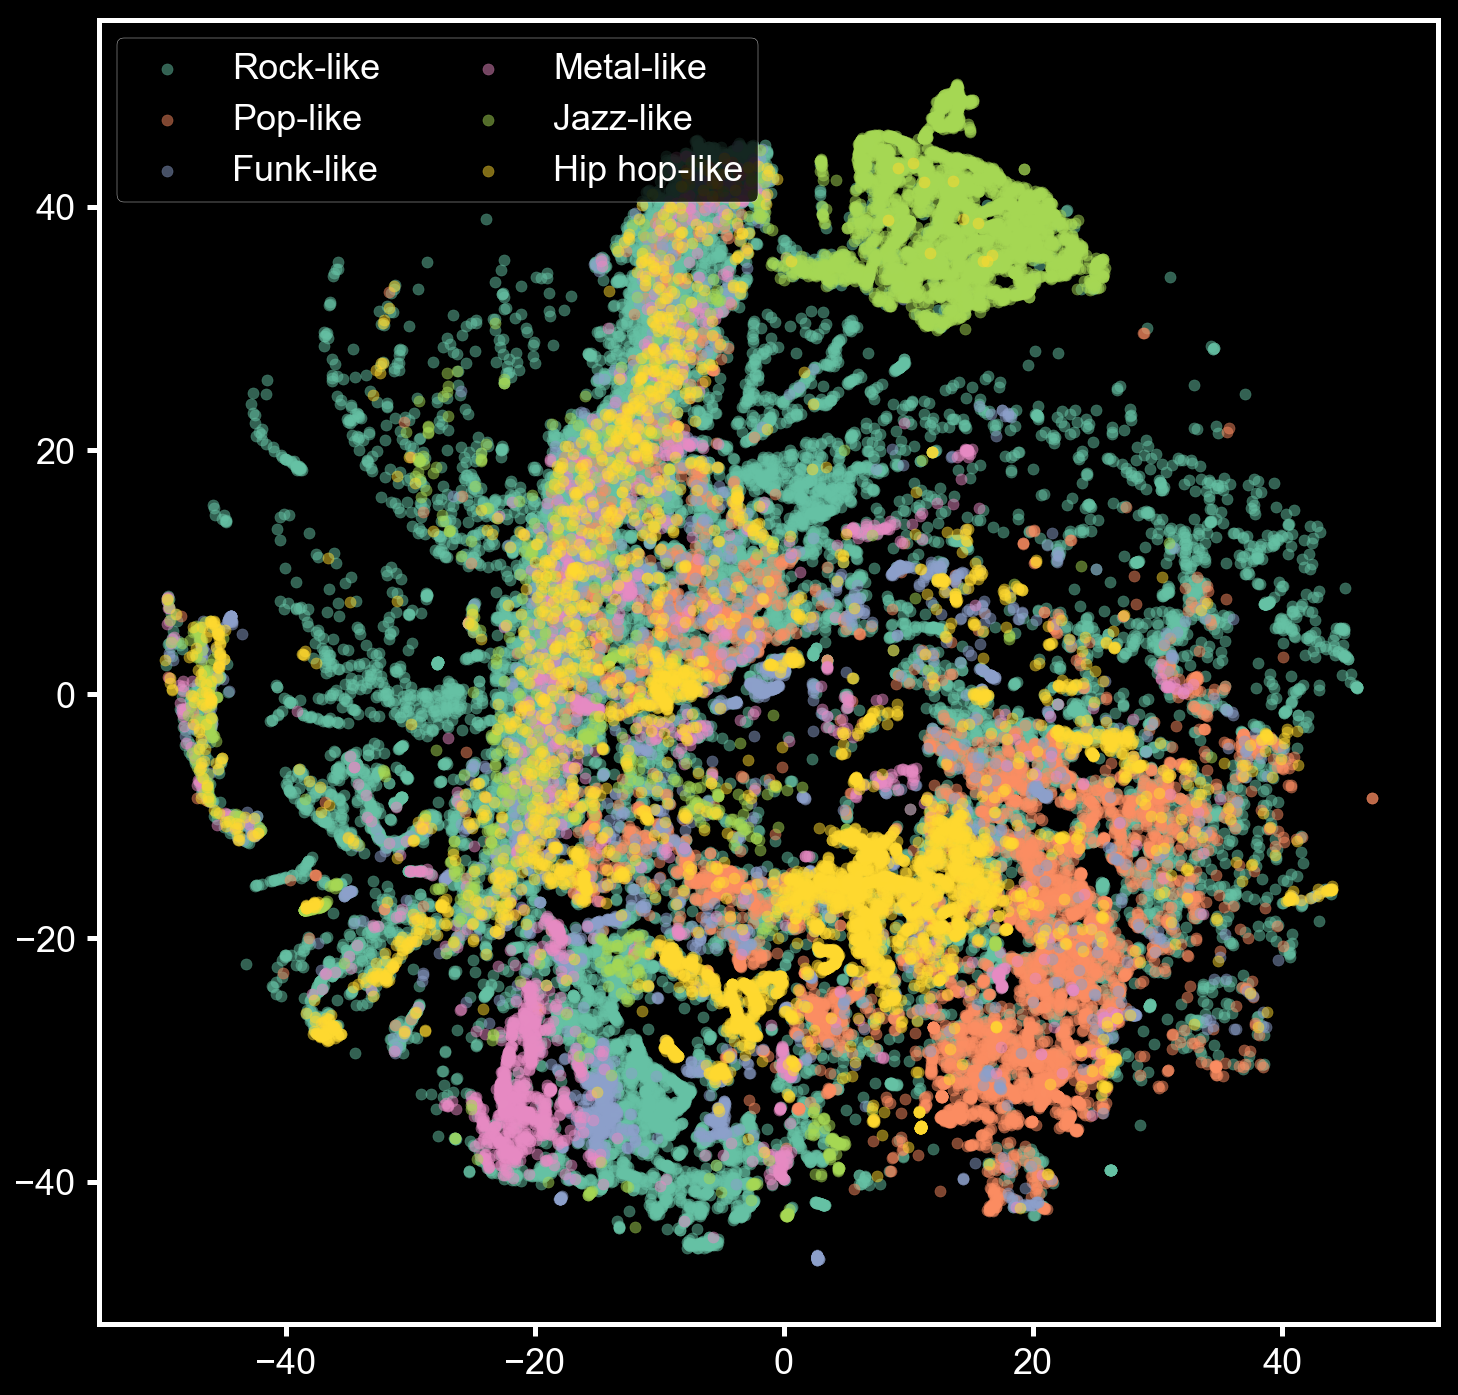

In [55]:
plt.style.use('dark_background')
plt.figure(figsize=(12,12))
pal = sns.color_palette('Set2',len(genre_topics))
for key,indx in genre_topics.items():
    X_sub = np.array([x for indx,x in enumerate(X_emb) if gtopic[indx]==key])
    plt.scatter(X_sub[:, 0], X_sub[:, 1],c=pal[key],alpha=0.5,label=indx)
leg = plt.legend(ncol=2,loc='upper left',frameon=True)
leg.get_frame().set_edgecolor('w')
plt.savefig('tsne_inv.svg')
plt.savefig('tsne_inv.png',dpi=300)
plt.show()

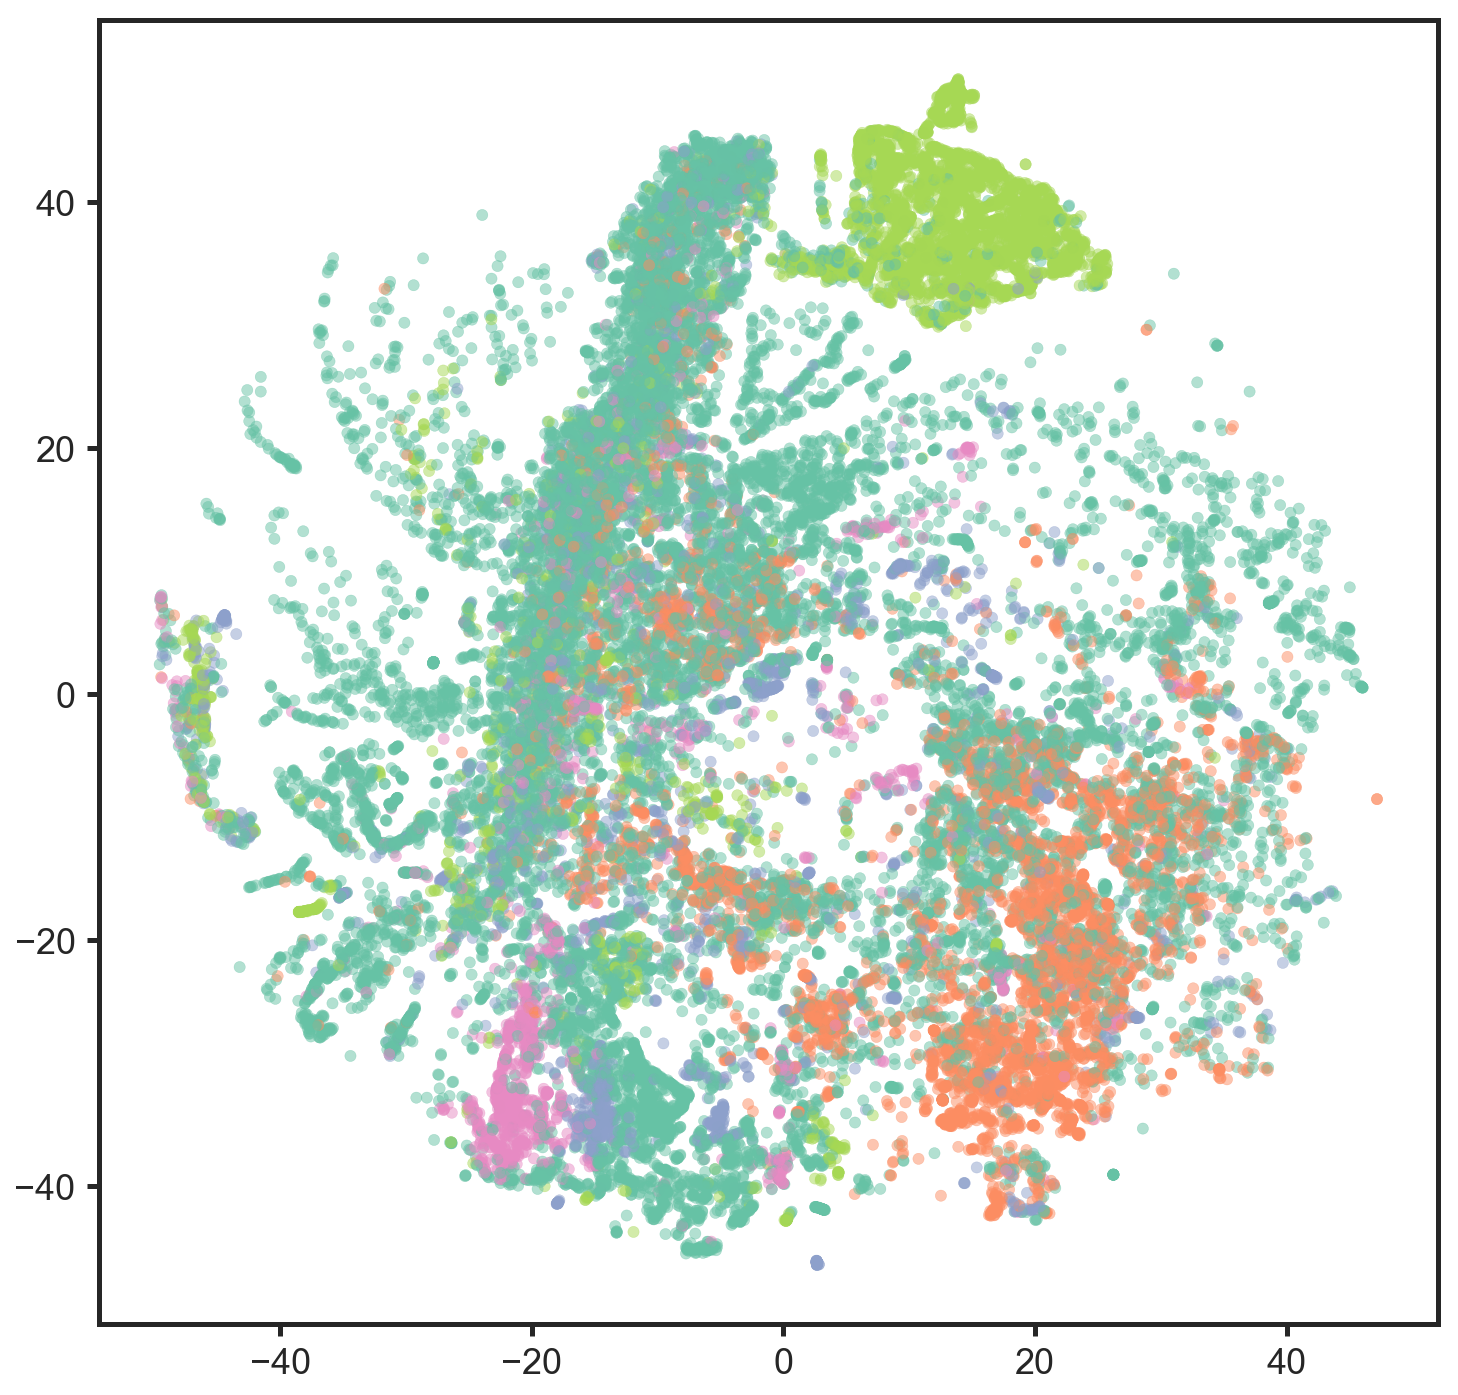

In [22]:
plt.figure(figsize=(12,12))
plt.scatter(X_sub[:, 0], X_sub[:, 1], c=c,alpha=0.5)
plt.show()

In [26]:
X_emb.shape

(108870, 2)

In [28]:
np.save('5k-TSNE',X_emb)
np.save('5k-gtopics',gtopic)